In [5]:
from ddpm_conditional import *
import pickle
# import torch_utils

/home/jechmate/anaconda3/envs/eli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import src.dataset as dataset
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("data/gain50/4/0.png", cv2.IMREAD_UNCHANGED)
img = dataset.add_fingerprint(img)
img[0:6, 0:6]

array([[255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255]], dtype=uint8)

In [4]:
from tqdm import tqdm
img_files = dataset.get_list_of_imgs("data/gain50", "*.png")
imgs = [cv2.imread(x, cv2.IMREAD_UNCHANGED) for x in img_files]
for file, img in tqdm(zip(img_files, imgs)):
    img = dataset.add_fingerprint(img, size=8)
    cv2.imwrite(file, img)

1279it [00:01, 940.52it/s]


In [ ]:
with open('models/edm-afhqv2-64x64-uncond-ve.pkl', 'rb') as f:
    ckpt = pickle.load(f)

In [ ]:

# Load the extracted weights into the corresponding layers of model2
# model2.load_state_dict(weights, strict=False)
for param_tensor in ckpt['ema'].state_dict():
    print(param_tensor, "\t", ckpt['ema'].state_dict()[param_tensor].size())

In [ ]:
print(ckpt['ema'].model.enc.parameters())

In [ ]:
import pickle
from ddpm_conditional import *
import torch.onnx

device = 'cuda:1'
batch_size = 1

torch_model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/CFG_700_norm_fing/ema_ckpt.pt")
torch_model.load_state_dict(ckpt)
torch_model.eval()

x_t = torch.randn(batch_size, 1, 64, 128, requires_grad=True).to(device)
t = torch.randint(low=1, high=500, size=(batch_size,)).to(device)
settings = torch.randn(batch_size, 3, requires_grad=True).to(device)

# torch_out = torch_model(x_t, t, settings)

torch.onnx.export(torch_model,               # model being run
                  (x_t, t, settings),                         # model input (or a tuple for multiple inputs)
                  "diffAE.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['noised', 'timestep', 'settings'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}}
)

In [ ]:
import pickle
from ddpm_conditional import *
import torch.onnx

device = 'cuda:0'
batch_size = 1

with open('models/edm-afhqv2-64x64-uncond-ve.pkl', 'rb') as f:
    ckpt = pickle.load(f)
    torch_model = ckpt["ema"].to(device)
torch_model.eval()
batch_size = 1

x = torch.randn(batch_size, 3, 64, 64, requires_grad=False).to(device)
noise_labels = torch.randn(batch_size, 3, 64, 64, requires_grad=False).to(device)
class_labels = torch.randn(batch_size, 1, requires_grad=False).to(device)
torch_out = torch_model(x, noise_labels, class_labels)
summary(torch_model, noise_labels, class_labels)
# print(torch_out)
# for param_tensor in torch_model.state_dict():
#     print(param_tensor, "\t", torch_model.state_dict()[param_tensor].size())

# torch.onnx.export(torch_model,               # model being run
#                   (x, noise_labels, class_labels),                         # model input (or a tuple for multiple inputs)
#                   "edm.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=9,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['im', 'noise', 'class'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}}
# )

# x_t = torch.randn(batch_size, 64, 128, requires_grad=True)
# t = torch.randn(batch_size, , requires_grad=True)
# settings = torch.randn(batch_size, 1, 64, 128, requires_grad=True)

# torch_out = ckpt(x_t, t, settings)


In [ ]:
import pandas as pd

def min_max_norm(col):
    return (col - col.min()) / (col.max() - col.min())

pd.read_csv("params.csv", engine='python')[["E","perc_N","P","gain","ms"]].apply(min_max_norm)

In [ ]:
import numpy as np
import torch

device = "cuda:2"
width = 128
height = 64
freqs_hor = np.pi*torch.linspace(0, width-1,width).to(device)/width
freqs_ver = np.pi*torch.linspace(0, height-1,height).to(device)/height
frequencies_squared = freqs_hor[:, None]**2 + freqs_ver[None, :]**2
frequencies_squared.shape

In [ ]:
import cv2
from matplotlib import pyplot as plt

im = cv2.imread("processed/6/26.png", cv2.IMREAD_UNCHANGED)
plt.imshow(im, vmin=0, vmax=255)

In [ ]:
im_res = cv2.resize(im, (128, 64))
im_res = cv2.resize(im_res, (512, 256))
plt.imshow(im_res, vmin=0, vmax=255)

In [ ]:
import dataset
deflection_MeV, spectrum_calibrated = dataset.get_1d(im/255, electron_pointing_pixel=62)

plt.title('Reconstructed Spectrum')
# print(spectrum_calibrated)
plt.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
plt.ylabel('Spectral Intensity (pA/MeV)')
plt.xlabel('Energy (MeV)')
plt.xlim([2, 8])
# plt.ylim([0, 130])

In [ ]:
import dataset
deflection_MeV, spectrum_calibrated = dataset.get_1d(im_res/255, electron_pointing_pixel=62)

plt.title('Reconstructed Spectrum')
# print(spectrum_calibrated)
plt.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
plt.ylabel('Spectral Intensity (pA/MeV)')
plt.xlabel('Energy (MeV)')
plt.xlim([2, 8])
# plt.ylim([0, 130])

In [ ]:
import cv2
from matplotlib import pyplot as plt
import dataset
import os
import numpy as np
def plot_average_image_pairs(root_folder, electron_pointing_pixel=62, noise=0.11):
    subfolders = sorted([f.path for f in os.scandir(root_folder) if f.is_dir()])
    n = len(subfolders)
    fig, axs = plt.subplots(n, 2, figsize=(15, 4*n))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    for i, subfolder in enumerate(subfolders):
        images = []
        for filename in os.listdir(subfolder):
            if filename.endswith(".png"):
                im = cv2.imread(os.path.join(subfolder, filename), cv2.IMREAD_UNCHANGED)
                images.append(im)
        avg_im = np.mean(images, axis=0)
        deflection_MeV, spectrum_calibrated = dataset.get_1d(avg_im/255, electron_pointing_pixel=electron_pointing_pixel, noise=noise)

        axs[i, 1].plot(deflection_MeV, spectrum_calibrated)  # plot without fit
        axs[i, 1].set_title('Reconstructed Spectrum')
        axs[i, 1].set_ylabel('Spectral Intensity (pA/MeV)')
        axs[i, 1].set_xlabel('Energy (MeV)')
        axs[i, 1].set_xlim([2, 20])
        axs[i, 0].imshow(avg_im, vmin=0, vmax=255)
        axs[i, 0].set_title(os.path.basename(subfolder))
    plt.show()

In [ ]:
plot_average_image_pairs("processed", noise=0.11)

In [12]:
import cv2
from matplotlib import pyplot as plt
import src.dataset
import os
import numpy as np
import pandas as pd

In [10]:
def show_image_spectra(im, image_gain=0, acq_time=0.11, electron_pointing_pixel=62):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    deflection_MeV, spectrum_calibrated = src.dataset.get_1d(im/255, electron_pointing_pixel=electron_pointing_pixel, image_gain=image_gain, acquisition_time_ms=acq_time)

    ax2.plot(deflection_MeV, spectrum_calibrated)  # plot without fit
    ax2.set_title('Reconstructed Spectrum')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)')
    ax2.set_xlabel('Energy (MeV)')
    ax2.set_xlim([2, 20])
    ax1.imshow(im, vmin=0, vmax=255)
    ax1.set_title("Image")
    plt.show()

20


TypeError: get_1d() missing 1 required positional argument: 'acquisition_time_ms'

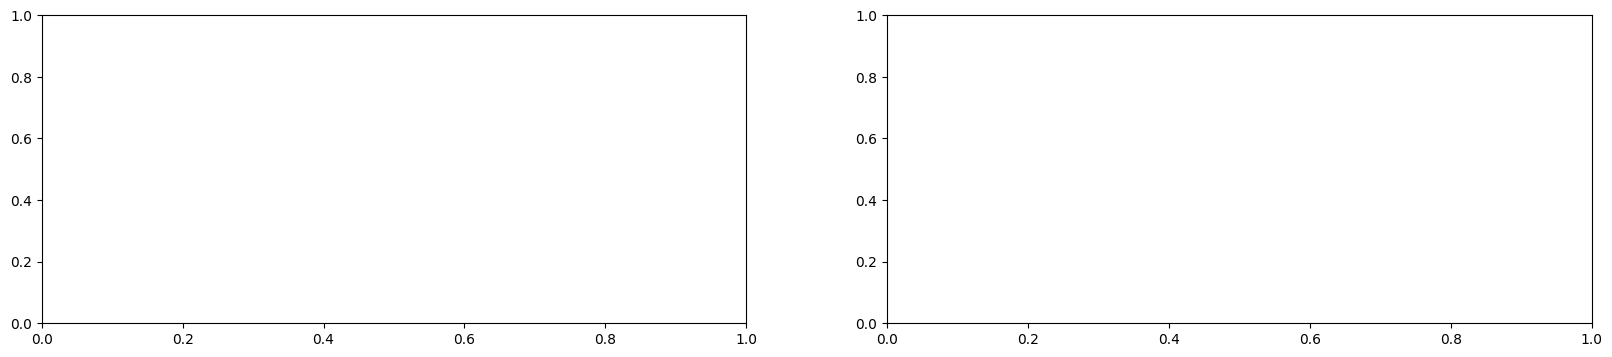

In [23]:
impath = "4/0.png"
my_gain = cv2.imread("data/train_bigger/" + impath, cv2.IMREAD_UNCHANGED)
their_gain = cv2.imread("data/with_gain/" + impath, cv2.IMREAD_UNCHANGED)
settings = pd.read_csv('data/params.csv')

acq_time = settings['ms'][3]
show_image_spectra(my_gain, image_gain=0, acq_time=acq_time)
show_image_spectra(their_gain, image_gain=0, acq_time=acq_time)

In [3]:
from src.utils import *

stitch_images("results/physinf_noclamp")

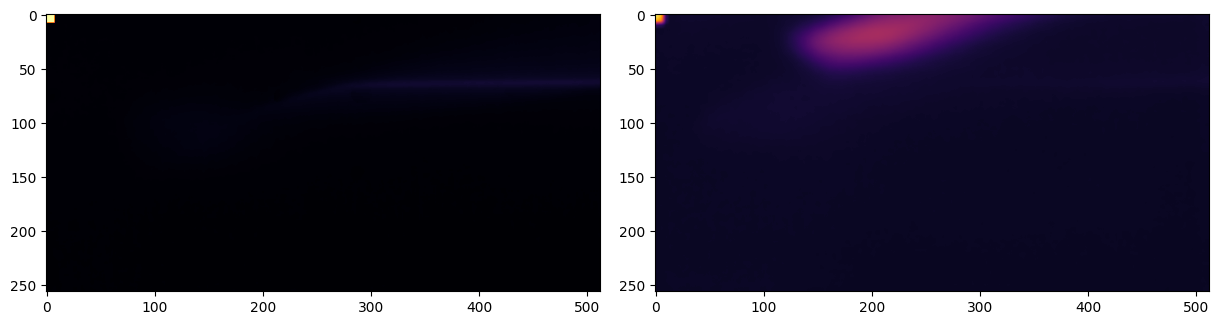

In [19]:
from metrics import *
import matplotlib.pyplot as plt

def compare_avg_plot(im1, im2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    axs[0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
    axs[1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
    plt.show()

def compare_avg_plots(real_root, sample_root)

im1, im2 = compare_avg("with_gain/17", "results/transfer_withgain_512_valid/no_17")
compare_avg_plot(im1, im2)


In [ ]:
def plot_average_pairs(real_root, sample_root):
    n = len(os.listdir(sample_root))
    fig, axs = plt.subplots(n, 2, figsize=(15, 4*n))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    for i in range(n):
        im1, im2 = compare_avg(os.path.join(real_root, n + 1), os.path.join(sample_root, "no_" + str(n + 1)))
        axs[i, 0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
        axs[i, 0].set_title(f'Experiment {i + 1}, real')
        axs[i, 1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
        axs[i, 1].set_title(f'Sampled')
    plt.show()

In [1]:
import scipy
mat = scipy.io.loadmat('Deflection_curve_Mixture_Feb28.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun  9 10:51:13 2022',
 '__version__': '1.0',
 '__globals__': [],
 'deflection_Mix': array([[122.382 ,   1.3238],
        [113.1797,   1.4117],
        [ 83.9496,   1.8423],
        [ 75.1443,   2.0471],
        [ 68.2294,   2.2489],
        [ 62.4582,   2.4547],
        [ 53.8108,   2.8523],
        [ 45.6837,   3.3718],
        [ 39.7447,   3.8922],
        [ 35.822 ,   4.3338],
        [ 32.6297,   4.7734],
        [ 30.4251,   5.132 ],
        [ 28.6947,   5.4527],
        [ 26.972 ,   5.8133],
        [ 26.4405,   5.9342],
        [ 24.371 ,   6.4557],
        [ 22.2446,   7.0931],
        [ 20.5504,   7.6955],
        [ 18.9303,   8.3728],
        [ 17.9293,   8.8523],
        [ 16.5427,   9.6126],
        [ 15.651 ,  10.172 ],
        [ 14.8498,  10.7325],
        [ 14.3008,  11.152 ],
        [ 13.6285,  11.7115],
        [ 13.0165,  12.2709],
        [ 12.3803,  12.9103],
        [ 11.944 ,  13.3878],
   

In [1]:
from src.dataset import read_img
import cv2

img = read_img("data/test/8_11.tiff")
img = img / 16 / 4095
cv2.imwrite("original.png", img*255)

True

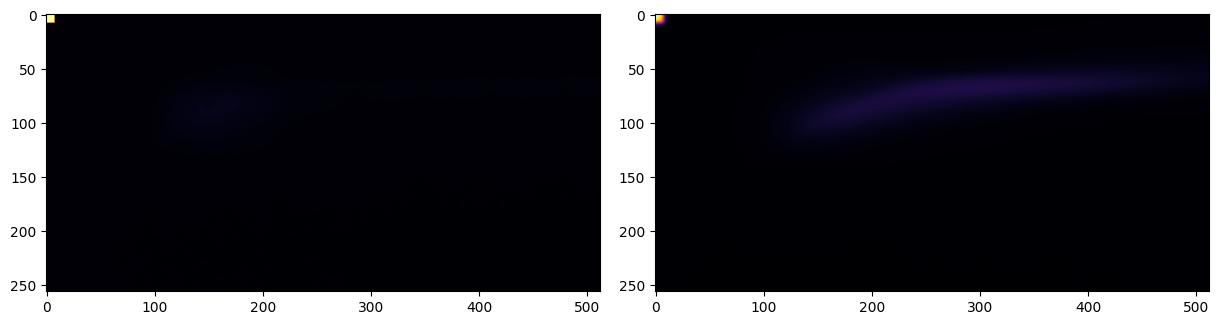

{'mse': tensor(787.7405), 'mse_norm': tensor(0.0002), 'dtw_dist': 414.08149948777964, 'ssim': tensor(0.8735, dtype=torch.float64)}


In [13]:
from metrics import *
import matplotlib.pyplot as plt
from src.utils import deflection_calc

def compare_avg_plot(im1, im2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.35)  # Increase the space between rows
    fig.subplots_adjust(wspace=0.1)  # Decrease the space between columns
    axs[0].imshow(im1, vmin=0, vmax=255, cmap='inferno')
    axs[1].imshow(im2, vmin=0, vmax=255, cmap='inferno')
    plt.show()

def plot_spectra(sp1, sp2, el_pointing_pixel=62):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    deflection_MeV = deflection_calc(1, len(sp1), el_pointing_pixel).flatten()
    ax1.plot(deflection_MeV, sp1)  # plot without fit
    ax1.set_title('Reconstructed Spectrum1')
    ax1.set_ylabel('Spectral Intensity (pA/MeV)')
    ax1.set_xlabel('Energy (MeV)')
    ax1.set_xlim([2, 20])
    ax2.plot(deflection_MeV, sp2)  # plot without fit
    ax2.set_title('Reconstructed Spectrum2')
    ax2.set_ylabel('Spectral Intensity (pA/MeV)')
    ax2.set_xlabel('Energy (MeV)')
    ax2.set_xlim([2, 20])
    plt.show()

dirnum = 11

dir1 = 'data/with_gain/' + str(dirnum)
dir2 = 'results/valid_nophys_1000ns_sec25_cfg3/' + str(dirnum)

res, spectra = compare_spectra(dir1, dir2, dirnum)
img1, img2 = compare_avg(dir1, dir2)
compare_avg_plot(img1, img2)
print(res)
# plot_spectra(sp1, sp2)

In [1]:
from src.dataset import *

set_gain_all(Path("data/with_gain"), Path("data/gain50"))

100%|██████████| 22/22 [00:02<00:00,  7.93it/s]


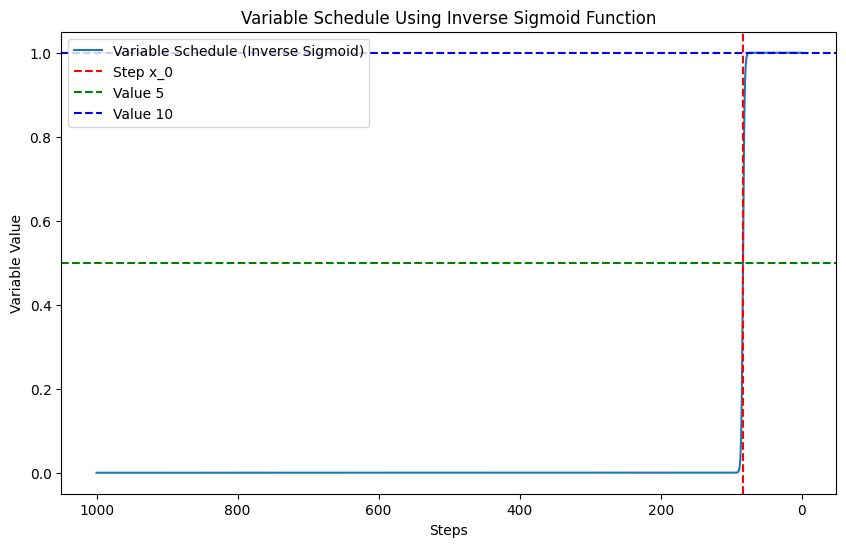

In [5]:
import numpy as np
import matplotlib.pyplot as plt
noise_steps = 1000
# Define the step range
steps = np.arange(noise_steps, 0, -1)  # From 850 to 85

# Define sigmoid function parameters
x_0 = noise_steps/12  # Center point of the sigmoid, chosen to ensure the steep increase happens around step 85
k = 0.9  # Steepness of the curve
scale = 1

inverse_sigmoid_schedule = scale - (scale / (1 + np.exp(-k * (steps - x_0))))

# Plotting the inverted sigmoid schedule
plt.figure(figsize=(10, 6))
plt.plot(steps, inverse_sigmoid_schedule, label='Variable Schedule (Inverse Sigmoid)')
plt.xlabel('Steps')
plt.ylabel('Variable Value')
plt.title('Variable Schedule Using Inverse Sigmoid Function')
plt.axvline(x=x_0, color='r', linestyle='--', label='Step x_0')
plt.axhline(y=scale/2, color='g', linestyle='--', label='Value 5')
plt.axhline(y=scale, color='b', linestyle='--', label='Value 10')
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to show the decreasing steps correctly
plt.show()

tensor(-0.0027) tensor(1.0731)
tensor(2.9352) tensor(3.0024)
Ratio: tensor([7.2774])


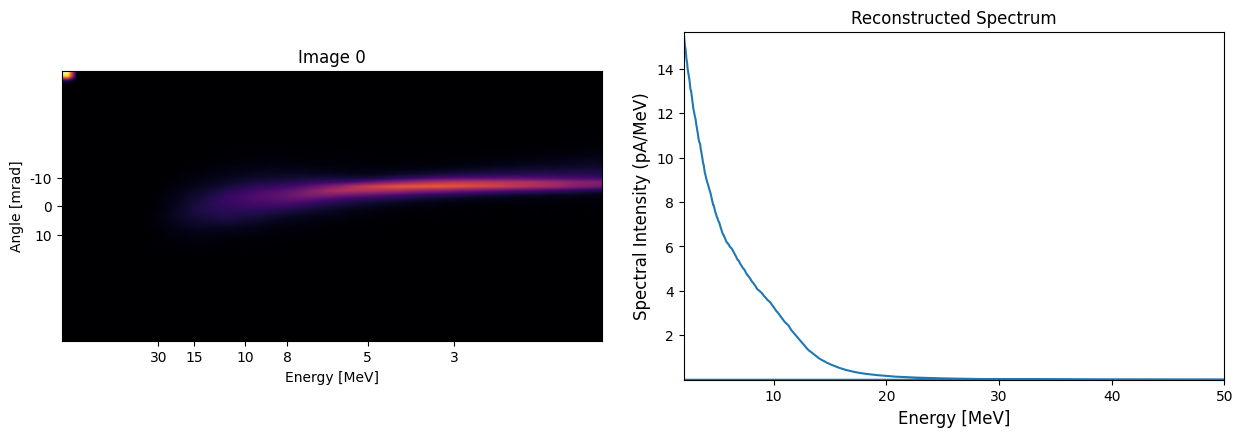

In [20]:
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib as mpl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import cv2
import glob
import src.dataset as dataset
import scipy
import torchvision.transforms.functional as f
from src.utils import load_images_from_dir, find_ticks


def bi_exponential_deflection(x, a1=77.855568601465, b1=0.466485822903793, a2=19.911755340829, b2=0.043573073167125255):
    return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)

def bi_exponential_deflection_dx(x, a1=-36.318518986697, b1=0.466485822903793, a2=-0.86761637235184, b2=0.043573073167125255):
    return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)

# def bi_exponential_deflection_dxdx(x, a1=-16.942074216156, b1=0.466485822903793, a2=-0.037804711673483, b2=0.043573073167125255):
#     return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)

def deflection_calc(batch_size, hor_image_size, electron_pointing_pixel):
    pixel_in_mm = 0.137
    deflection_MeV = torch.zeros((batch_size, hor_image_size))
    deflection_mm = torch.zeros((batch_size, hor_image_size))
    mat = scipy.io.loadmat('data/Deflection_curve_Mixture_Feb28.mat')
    for i in range(hor_image_size):
        if i <= electron_pointing_pixel:
            deflection_mm[:, i] = 0
        else:
            deflection_mm[:, i] = (i - electron_pointing_pixel) * pixel_in_mm
            
    for i in range(electron_pointing_pixel, hor_image_size):
        xq = deflection_mm[:, i]
        mask = xq > 1
        if mask.any():
            deflection_MeV[mask, i] = torch.from_numpy(scipy.interpolate.interp1d(mat['deflection_curve_mm'][:, 0],
                                                           mat['deflection_curve_MeV'][:, 0],
                                                           kind='linear',
                                                           assume_sorted=False,
                                                           bounds_error=False)(xq[mask]).astype(np.float32))
    return deflection_MeV


def deflection_biexp_calc(batch_size, hor_image_size, electron_pointing_pixel, pixel_in_mm=0.137):
    linear_space = torch.arange(hor_image_size) * pixel_in_mm
    linear_space -= electron_pointing_pixel * pixel_in_mm
    deflection_mm = linear_space.clamp(min=0)
    deflection_mm = deflection_mm.repeat(batch_size, 1)
    mask = deflection_mm > 1
    deflection_MeV = torch.zeros_like(deflection_mm)
    deflection_MeV_dx = torch.zeros_like(deflection_mm)
    deflection_MeV[mask] = bi_exponential_deflection(deflection_mm[mask]).to(torch.float32)
    deflection_MeV_dx[mask] = bi_exponential_deflection_dx(deflection_mm[mask]).to(torch.float32)
    return deflection_MeV, deflection_MeV_dx


def calc_spec(image, electron_pointing_pixel, deflection_MeV, acquisition_time_ms, image_gain=0, resize=None, noise=False, device='cpu', deflection_MeV_dx=None):
    if resize:
        image = f.resize(image, resize, antialias=True)
    image_gain /= 32  # correction for CCD settings
    if noise:
        noise = torch.median(torch.stack([
            image[:, :, int(image.shape[1] * 0.9), int(image.shape[2] * 0.05)],
            image[:, :, int(image.shape[1] * 0.9), int(image.shape[2] * 0.9)],
            image[:, :, int(image.shape[1] * 0.1), int(image.shape[2] * 0.9)]
        ], dim=0), dim=(1, 2))
        noise = noise.unsqueeze(1).unsqueeze(2)
        image[image <= noise] = 0

    hor_image_size = image.shape[-1]
    batch_size = image.shape[0]
    horizontal_profile = torch.sum(image, dim=(1, 2)).to(device)

    spectrum_in_pixel = torch.zeros((batch_size, hor_image_size)).to(device)
    spectrum_in_MeV = torch.zeros((batch_size, hor_image_size)).to(device)

    # Fill spectrum_in_pixel for all pixels at once
    spectrum_in_pixel[:, electron_pointing_pixel:] = horizontal_profile[:, electron_pointing_pixel:]

    # Compute the derivative array
    deflection_MeV_shifted = torch.roll(deflection_MeV, shifts=-1, dims=1)
    if deflection_MeV_dx is None:
        derivative = deflection_MeV[:, :-1] - deflection_MeV_shifted[:, :-1]
    else:
        derivative = -deflection_MeV_dx[:, electron_pointing_pixel:]

    derivative_method1 = deflection_MeV[:, :-1] - deflection_MeV_shifted[:, :-1]
    derivative_method2 = -deflection_MeV_dx[:, electron_pointing_pixel:]
    print(torch.mean(derivative_method1), torch.mean(derivative_method2))
    print(torch.std(derivative_method1), torch.std(derivative_method2))

    # plt.figure(figsize=(10, 6))
    # plt.plot(torch.abs(derivative_method1).squeeze(), label='Method 1: Difference', linestyle='--')
    # plt.plot(range(electron_pointing_pixel, 512), derivative_method2.squeeze(), label='Method 2: Provided Derivative', marker='o', linestyle='None')
    # plt.title("Comparison of Derivative Calculation Methods")
    # plt.xlabel("Pixel Index")
    # plt.ylabel("Derivative Value")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    # plt.close()

    derivative = derivative.to(device)
    mask = derivative != 0
    derivative_expanded = derivative.expand_as(spectrum_in_pixel[:, electron_pointing_pixel:])

    print("Ratio:", -deflection_MeV_dx[:, 250] / (deflection_MeV[:, 250-1] - deflection_MeV[:, 250]))

    # Calculate the spectrum in MeV, avoiding division by zero
    spectrum_in_MeV[:, electron_pointing_pixel:][mask] = spectrum_in_pixel[:, electron_pointing_pixel:][mask] / derivative_expanded[mask]

    spectrum_in_MeV[~torch.isfinite(spectrum_in_MeV)] = 0

    acquisition_time_ms = acquisition_time_ms.reshape(batch_size, 1).repeat(1, hor_image_size).to(device)
    spectrum_calibrated = (spectrum_in_MeV * 3.706) / (acquisition_time_ms * image_gain) if image_gain else (spectrum_in_MeV * 3.706) / acquisition_time_ms

    return deflection_MeV, spectrum_calibrated


def plot_image_pairs(images, acquisition_time_ms, beam_point_x, beam_point_y, energy, pressure, xlim=[2, 20], model=1, gain=0, noise=False):
    def get_y_lims_within_xlim(x, y, xlim):
        """Find the min and max y-values within the specified x-limits using PyTorch."""
        within_xlim = (x >= xlim[0]) & (x <= xlim[1])
        y_within_xlim = y[within_xlim]
        return [torch.min(y_within_xlim), torch.max(y_within_xlim)] if y_within_xlim.numel() > 0 else [torch.min(y), torch.max(y)]

    n = len(images)
    pixel_in_mrad = 0.3653
    energy_levels = [100, 30, 15, 10, 8, 5, 3]  # Removed 40 and 20
    ranges = [(70, 101), (20, 31), (12, 15.5), (8, 10.5), (6, 8.2), (4.8, 5.2), (2.9, 3.2)]  # Adjusted ranges

    fig, axs = plt.subplots(n, 2, figsize=(15, 4*n))
    fig.subplots_adjust(hspace=0.35, wspace=0.15, top=0.98)
    if n == 1:
        axs = axs.reshape(1, -1)
    deflection_MeV, deflection_MeV_dx = deflection_biexp_calc(n, images.shape[-1], beam_point_x)
    deflection_MeV = deflection_MeV[0].unsqueeze(0) # make it batched but of batchsize 1
    deflection_MeV_dx = deflection_MeV_dx[0].unsqueeze(0) # make it batched but of batchsize 1
    for i in range(n):
        im = images[i].unsqueeze(0).unsqueeze(0)
        deflection_MeV, spectrum_calibrated = calc_spec(im/255, beam_point_x, deflection_MeV, torch.tensor(acquisition_time_ms), image_gain=gain, noise=noise, deflection_MeV_dx=deflection_MeV_dx)  # Using a local function
        ticks = find_ticks(deflection_MeV.squeeze().cpu(), beam_point_x, beam_point_y, pixel_in_mrad, energy_levels, ranges)
        # Plot the spectrum
        axs[i, 1].plot(deflection_MeV.squeeze().cpu(), spectrum_calibrated.squeeze().cpu())
        axs[i, 1].set_title('Reconstructed Spectrum', fontsize=12)
        axs[i, 1].set_ylabel('Spectral Intensity (pA/MeV)', fontsize=12)
        axs[i, 1].set_xlabel('Energy [MeV]', fontsize=12)
        axs[i, 1].set_xlim(xlim)
        y_lims = get_y_lims_within_xlim(deflection_MeV, spectrum_calibrated, xlim)
        axs[i, 1].set_ylim(y_lims)

        # Plot the image
        axs[i, 0].imshow(im.squeeze().cpu(), vmin=0, vmax=255, cmap='inferno')
        axs[i, 0].set_title(f"Image {i}")

        # Set y-axis ticks for mrad values
        axs[i, 0].set_yticks([ticks['tick_10mrad_px'], ticks['tick0mrad_px'], ticks['tick10mrad_px']])
        axs[i, 0].set_yticklabels(['-10', '0', '10'])
        axs[i, 0].set_ylabel('Angle [mrad]')

        # Set x-axis ticks for MeV values
        mev_ticks = [tick for key, tick in ticks.items() if 'MeV' in key and tick is not None]
        axs[i, 0].set_xticks(mev_ticks)
        axs[i, 0].set_xticklabels([key.split('tick')[1].replace('MeV', '') for key in ticks if 'MeV' in key and ticks[key] is not None])
        axs[i, 0].set_xlabel('Energy [MeV]')
        # deflection_MeV = deflection_MeV.unsqueeze(0)
    plt.show()


E = 15
P = 15
ms = 20
x = f.pil_to_tensor(load_images_from_dir("results/1st_gain50_beamposnoweight", 4)[0])
plot_image_pairs(x, xlim=[2,50], acquisition_time_ms=ms, beam_point_y=128, beam_point_x=64, energy=E, pressure=P, model=1, noise=False)

tensor(99.4441)


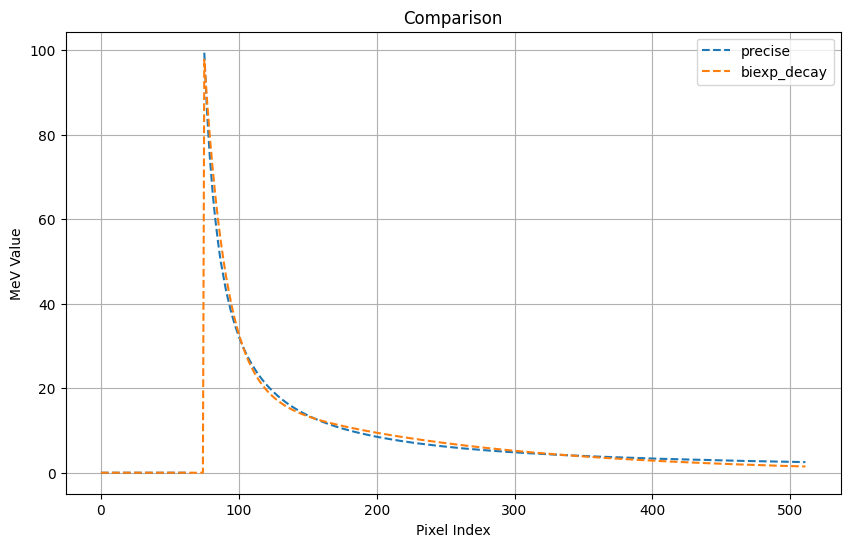

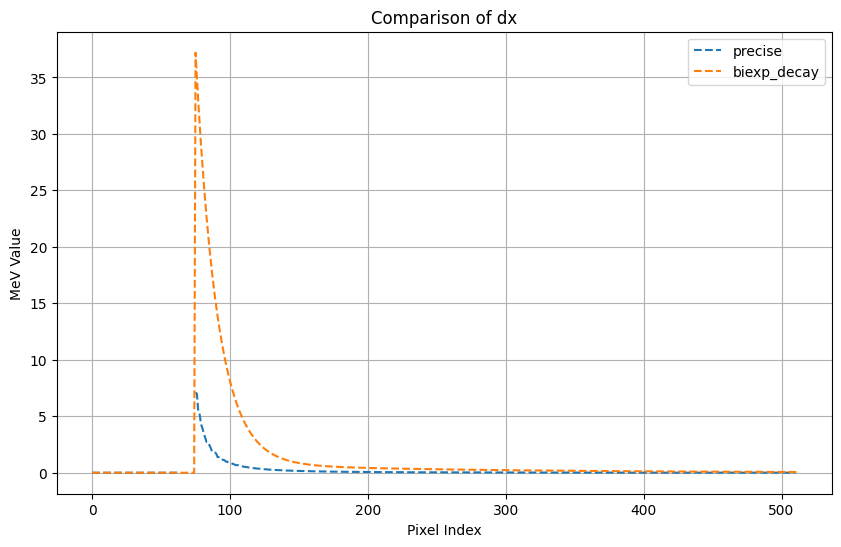

In [12]:
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib as mpl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import cv2
import glob
import src.dataset as dataset
import scipy
import torchvision.transforms.functional as f
from src.utils import load_images_from_dir, find_ticks

def bi_exponential_deflection(x, a1=77.855568601465, b1=0.466485822903793, a2=19.911755340829, b2=0.043573073167125255):
    return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)

def bi_exponential_deflection_dx(x, a1=-36.318518986697, b1=0.466485822903793, a2=-0.86761637235184, b2=0.043573073167125255):
    return a1 * torch.exp(-b1 * x) + a2 * torch.exp(-b2 * x)

def deflection_calc(batch_size, hor_image_size, electron_pointing_pixel):
    pixel_in_mm = 0.137
    deflection_MeV = torch.zeros((batch_size, hor_image_size))
    deflection_mm = torch.zeros((batch_size, hor_image_size))
    mat = scipy.io.loadmat('data/Deflection_curve_Mixture_Feb28.mat')
    for i in range(hor_image_size):
        # if i <= electron_pointing_pixel:
        #     deflection_mm[:, i] = 0
        # else:
        deflection_mm[:, i] = (i - electron_pointing_pixel) * pixel_in_mm
            
    for i in range(electron_pointing_pixel, hor_image_size):
        xq = deflection_mm[:, i]
        mask = xq > 0
        if mask.any():
            deflection_MeV[mask, i] = torch.from_numpy(scipy.interpolate.interp1d(mat['deflection_curve_mm'][:, 0],
                                                           mat['deflection_curve_MeV'][:, 0],
                                                           kind='linear',
                                                           assume_sorted=False,
                                                           bounds_error=False)(xq[mask]).astype(np.float32))
    return deflection_MeV#[:][electron_pointing_pixel:]


def deflection_biexp_calc(batch_size, hor_image_size, electron_pointing_pixel, pixel_in_mm=0.137):
    linear_space = torch.arange(hor_image_size) * pixel_in_mm
    linear_space = linear_space.repeat(batch_size, 1)
    # linear_space -= electron_pointing_pixel
    # deflection_mm = linear_space.clamp(min=0)
    # deflection_mm = deflection_mm.repeat(batch_size, 1)
    # mask = linear_space > 0
    # deflection_MeV = torch.zeros_like(deflection_mm)
    # deflection_MeV_dx = torch.zeros_like(deflection_mm)
    # deflection_mm = 
    deflection_MeV = bi_exponential_deflection(linear_space).to(torch.float32)
    zeros = torch.zeros(batch_size, 75)

    # Concatenate zeros to the beginning of each tensor in the batch
    deflection_MeV = torch.cat((zeros, deflection_MeV), dim=1)

    # Slice the concatenated tensor to keep only the first 512 elements in each tensor
    deflection_MeV = deflection_MeV[:, :512]
    deflection_MeV_dx = bi_exponential_deflection_dx(linear_space).to(torch.float32)
    deflection_MeV_dx = torch.cat((zeros, deflection_MeV_dx), dim=1)
    deflection_MeV_dx = deflection_MeV_dx[:, :512]
    return deflection_MeV, deflection_MeV_dx

# linear_space = torch.arange(512)
deflection_MeV_biexp, deflection_MeV_dx = deflection_biexp_calc(1, 512, 64)
deflection_MeV = deflection_calc(1, 512, 64)
print(deflection_MeV[0, 75])

plt.figure(figsize=(10, 6))
plt.plot(deflection_MeV.squeeze(), label='precise', linestyle='--')
plt.plot(range(0, 512), deflection_MeV_biexp.squeeze(), label='biexp_decay', linestyle='--')
plt.title("Comparison")
plt.xlabel("Pixel Index")
plt.ylabel("MeV Value")
plt.legend()
plt.grid(True)
plt.show()
plt.close()

deflection_MeV_shifted = torch.roll(deflection_MeV, shifts=-1, dims=1)
derivative_method1 = deflection_MeV[:, :-1] - deflection_MeV_shifted[:, :-1]
derivative_method2 = -deflection_MeV_dx[:, :]

plt.figure(figsize=(10, 6))
plt.plot(derivative_method1.squeeze(), label='precise', linestyle='--')
plt.plot(range(0, 512), derivative_method2.squeeze(), label='biexp_decay', linestyle='--')
plt.title("Comparison of dx")
plt.xlabel("Pixel Index")
plt.ylabel("MeV Value")
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [2]:
import torch

def sigmoid_schedule(step, max_steps=1000, k=0.9):
    scale = 1
    x_0 = max_steps/10
    return scale - (scale / (1 + torch.exp(-k * (step - x_0))))

In [15]:
def create_sigmoid_list(length, total_sum):
    # Ensure that there's enough total sum to give at least 1 to each element
    assert total_sum >= length, "Total sum must be at least equal to the length of the list"

    # Generate sigmoid values across the specified range in reverse to distribute larger values first
    sigmoid_values = torch.tensor([sigmoid_schedule(torch.tensor(i), max_steps=length, k=0.9) for i in range(length, 0, -1)])

    # Normalize these sigmoid values so that their sum is 1
    normalized_sigmoid_values = sigmoid_values / torch.sum(sigmoid_values)

    # Calculate the sum available after assigning 1 to each element
    available_sum = total_sum - length

    # Scale these normalized values to the available sum
    scaled_sigmoid_values = normalized_sigmoid_values * available_sum

    # Start each element with 1 and add the scaled sigmoid values, then round
    integer_list = (torch.ones(length) + scaled_sigmoid_values).int().tolist()

    # Correct any discrepancies in sum due to rounding
    current_sum = sum(integer_list)
    difference = total_sum - current_sum
    
    # Adjust by adding/subtracting 1 to elements until the sum is correct
    if difference != 0:
        sign = int(difference / abs(difference))  # Determine if we need to add or subtract
        indices = list(range(length))
        torch.randperm(len(indices)).tolist()  # Shuffle indices for fairness in adjustment

        for i in indices:
            if difference == 0:
                break
            integer_list[i] += sign
            difference -= sign
    
    return integer_list

# Example usage
length = 10  # Length of the list
total_sum = 100  # Desired sum of the list
adjusted_list = create_sigmoid_list(length, total_sum)
print("Adjusted List:", adjusted_list)

Adjusted List: [0, 0, 0, 0, 1, 3, 6, 14, 28, 48]


In [13]:
import torch

sigmoid_schedule(torch.tensor(100))

tensor(0.5000)

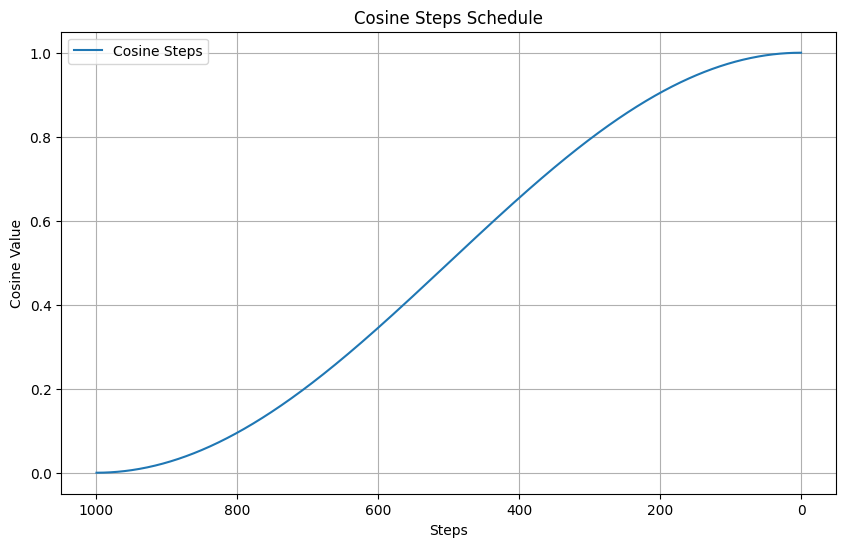

In [7]:
import torch
import matplotlib.pyplot as plt

def cosine_step_schedule(noise_steps):
    t = torch.linspace(0, 1, noise_steps)
    return 0.5 * (1 + torch.cos(t * torch.pi))

# Generate cosine steps
noise_steps = 1000
cosine_steps = cosine_step_schedule(noise_steps)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cosine_steps.numpy(), label='Cosine Steps')
plt.title('Cosine Steps Schedule')
plt.xlabel('Steps')
plt.ylabel('Cosine Value')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to show the decreasing steps correctly
plt.show()